# Paper ST Sloping - 10 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import random
import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_10beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,39.341333,39.831764,39.826684,11.282887,1.634628,0.913825,-0.771782,-1.359522,-0.634856,...,-0.049375,0.037769,-0.045755,0.051531,-0.078515,0.013704,-0.024545,-0.017430,0.001676,NSR
1,e0106,43.320409,45.006516,44.365681,12.474802,1.826689,0.901002,-0.707731,-1.281504,-0.731562,...,-0.033106,0.009999,-0.014494,0.028882,-0.048873,-0.010926,-0.026088,0.009880,-0.021702,NSR
2,e0106,41.841597,41.778007,41.593833,11.837152,1.721631,0.911361,-0.728350,-1.293684,-0.729167,...,-0.049280,0.038759,-0.048515,0.056363,-0.076889,-0.002209,-0.011804,-0.015943,-0.006355,NSR
3,e0106,43.146961,41.264063,41.075821,11.843259,1.752020,0.906516,-0.728333,-1.275260,-0.678176,...,-0.065776,0.050750,-0.050526,0.048861,-0.084336,0.026353,-0.035720,-0.018588,0.013943,NSR
4,e0106,41.647822,43.131905,43.437246,12.388259,1.809692,0.915806,-0.758906,-1.398698,-0.864005,...,-0.049441,0.035196,-0.047893,0.061977,-0.082722,0.004341,-0.018094,-0.013906,-0.001004,NSR


In [5]:
data['label'].value_counts()

NSR    41933
ST-     8802
ST+     3950
Name: label, dtype: int64

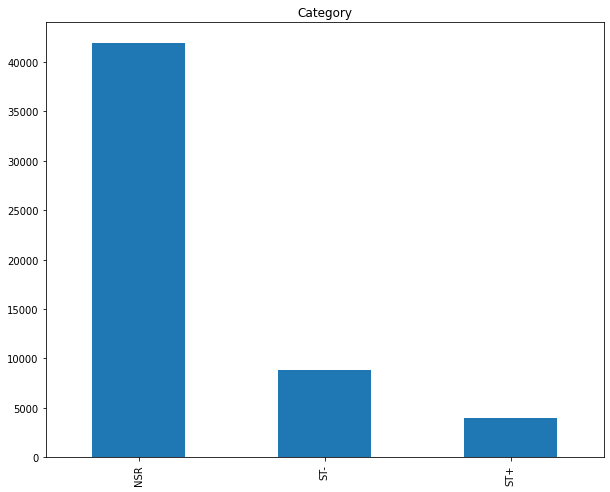

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.231317,0.109459,0.074913,0.064543,0.101660,-0.029506,0.023452,-0.001861,0.003290,...,-0.062028,-0.061241,-0.032516,-0.026775,-0.017739,-0.046809,-0.035437,-0.049050,-0.071846,-0.053104
dw_2,0.231317,1.000000,0.839064,0.449006,0.157026,0.490259,-0.520594,-0.307376,-0.002765,0.011760,...,-0.133566,0.150743,0.235204,0.167194,0.046752,0.030436,0.119758,0.004610,-0.117053,-0.076826
dw_3,0.109459,0.839064,1.000000,0.626999,0.236381,0.373744,-0.580056,-0.413234,-0.000351,0.005808,...,-0.207216,0.129536,0.268782,0.117633,-0.049634,0.054751,0.045877,-0.023444,-0.131465,-0.047859
dw_4,0.074913,0.449006,0.626999,1.000000,0.896524,0.070236,-0.268424,-0.208628,0.000763,0.001641,...,-0.143689,0.054827,0.109764,0.050373,-0.044638,0.044048,0.026303,-0.031429,-0.089388,-0.036217
dw_5,0.064543,0.157026,0.236381,0.896524,1.000000,-0.079160,-0.026334,-0.035523,0.000409,-0.000153,...,-0.061473,0.009140,0.005657,0.023553,-0.012439,0.016599,0.014533,-0.033413,-0.041393,-0.021446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.046809,0.030436,0.054751,0.044048,0.016599,-0.081643,0.054039,0.087235,-0.001785,0.005388,...,-0.130493,-0.207093,-0.090454,0.024675,0.059365,1.000000,0.008142,-0.011310,-0.326522,-0.216222
cfr_13,-0.035437,0.119758,0.045877,0.026303,0.014533,0.076890,-0.003660,0.006739,0.002726,-0.000638,...,0.133437,0.032750,-0.215151,-0.269635,-0.033375,0.008142,1.000000,0.199386,0.109416,-0.168514
cfr_14,-0.049050,0.004610,-0.023444,-0.031429,-0.033413,0.021208,0.025601,0.029224,0.003070,-0.002968,...,0.098660,0.217327,0.047811,-0.175074,-0.289421,-0.011310,0.199386,1.000000,0.171805,-0.139323
cfr_15,-0.071846,-0.117053,-0.131465,-0.089388,-0.041393,-0.006682,0.103513,0.057917,0.004848,-0.008763,...,0.266212,0.164693,-0.079613,-0.147027,-0.089111,-0.326522,0.109416,0.171805,1.000000,0.253573


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### Exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_166', 'fft_243', 'fft_250', 'fft_204', 'fft_167', 'fft_238', 'fft_246', 'fft_179', 'fft_237', 'fft_168', 'fft_197', 'fft_215', 'fft_157', 'fft_207', 'fft_163', 'cfr_16', 'mfw_5', 'mfw_16', 'fft_186', 'fft_191', 'mfw_8', 'fft_235', 'fft_212', 'fft_159', 'fft_241', 'fft_234', 'fft_177', 'mfw_13', 'fft_150', 'mfw_11', 'fft_152', 'fft_141', 'fft_224', 'fft_153', 'fft_151', 'fft_164', 'fft_183', 'fft_188', 'fft_219', 'fft_156', 'fft_130', 'fft_133', 'fft_135', 'fft_253', 'fft_181', 'fft_134', 'fft_139', 'fft_182', 'fft_255', 'fft_213', 'fft_196', 'fft_202', 'fft_236', 'fft_240', 'fft_229', 'fft_149', 'fft_249', 'fft_170', 'fft_251', 'fft_247', 'fft_214', 'fft_242', 'fft_226', 'fft_248', 'fft_189', 'fft_221', 'mfw_12', 'fft_180', 'fft_132', 'fft_154', 'fft_158', 'fft_176', 'fft_144', 'fft_162', 'fft_228', 'mfw_6', 'fft_175', 'fft_140', 'fft_256', 'fft_252', 'fft_165', 'fft_231', 'fft_217', 'mfw_15', 'fft_173', 'fft_232', 'fft_211', 'fft_200', 'fft_206', 'fft_195', 'fft_172', 'fft_143',

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_24
fft_25
fft_26
fft_27
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
fft_38
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_11
ar_12
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 77


### Visualization best features

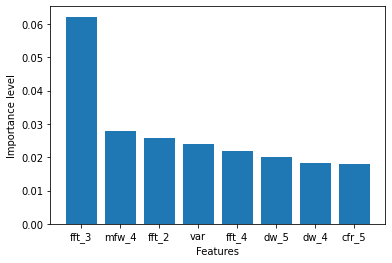

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,39.341333,39.831764,39.826684,11.282887,1.634628,0.913825,-0.771782,-1.359522,-0.634856,0.232364,...,0.019450,0.044698,-0.049375,0.037769,-0.045755,0.051531,-0.078515,0.013704,-0.024545,-0.017430
1,43.320409,45.006516,44.365681,12.474802,1.826689,0.901002,-0.707731,-1.281504,-0.731562,-1.393341,...,0.013422,0.040336,-0.033106,0.009999,-0.014494,0.028882,-0.048873,-0.010926,-0.026088,0.009880
2,41.841597,41.778007,41.593833,11.837152,1.721631,0.911361,-0.728350,-1.293684,-0.729167,-1.923488,...,0.010183,0.036844,-0.049280,0.038759,-0.048515,0.056363,-0.076889,-0.002209,-0.011804,-0.015943
3,43.146961,41.264063,41.075821,11.843259,1.752020,0.906516,-0.728333,-1.275260,-0.678176,-1.560684,...,0.001683,0.048352,-0.065776,0.050750,-0.050526,0.048861,-0.084336,0.026353,-0.035720,-0.018588
4,41.647822,43.131905,43.437246,12.388259,1.809692,0.915806,-0.758906,-1.398698,-0.864005,4.788369,...,0.015460,0.047792,-0.049441,0.035196,-0.047893,0.061977,-0.082722,0.004341,-0.018094,-0.013906


## Random Forest - 1000x random split

In [17]:
classes = np.unique(label_encoder.inverse_transform(y))

result_df = pd.DataFrame()

split_seeds = random.sample(range(1, 2**32 - 1), 1000)
smote_seeds = random.sample(range(1, 2**32 - 1), 1000)
for i, (split_seed, smote_seed) in enumerate(zip(split_seeds, smote_seeds)):
    start_time = time.time()

    # Train and Test split
    x_train, x_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.2, random_state=split_seed)
    smote = SMOTE(random_state=smote_seed, n_jobs=THREADS_TO_USE)
    x_smote, y_smote = smote.fit_resample(x_train, y_train)

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_smote, y_smote)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(split_seeds), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

#---------------------#
1 of 1000 - 30.297866106033325 s
Tot: Accuracy 0.9345341501325775 Precision 0.935214082232021 Recall 0.9345341501325775 Specificity 0.8962302973619901 F1 0.934679483946207
NSR: Accuracy 0.9350827466398464 Precision 0.9611650485436893 Recall 0.9540749553837001 Specificity 0.8720379146919431 F1 0.9576068784332458
ST+: Accuracy 0.9832678065282985 Precision 0.8441108545034642 Recall 0.938382541720154 Specificity 0.9867099822799764 F1 0.8887537993920973
ST-: Accuracy 0.9832678065282985 precision 0.8512731481481481 Recall 0.8391329150028523 Specificity 0.9720165505226481 F1 0.8451594369434071
#---------------------#
#---------------------#
2 of 1000 - 31.1610906124115 s
Tot: Accuracy 0.9330712261131937 Precision 0.9339681772653498 Recall 0.9330712261131937 Specificity 0.8987005939770687 F1 0.9333472649236286
NSR: Accuracy 0.9338941208740971 Precision 0.9616590306245478 Recall 0.9516764109294834 Specificity 0.8755868544600939 F1 0.9566416791604199
ST+: Accuracy 0.98372

In [18]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.934534,0.935214,0.934534,0.896230,0.934679,0.935083,0.961165,0.954075,0.872038,0.957607,0.983268,0.844111,0.938383,0.986710,0.888754,0.983268,0.851273,0.839133,0.972017,0.845159
1,0.933071,0.933968,0.933071,0.898701,0.933347,0.933894,0.961659,0.951676,0.875587,0.956642,0.983725,0.849650,0.937018,0.987302,0.891198,0.983725,0.840336,0.843645,0.968883,0.841987
2,0.932614,0.933006,0.932614,0.888482,0.932652,0.932797,0.959123,0.953555,0.862635,0.956331,0.985096,0.859485,0.944659,0.988189,0.900061,0.985096,0.838061,0.824419,0.970272,0.831184
3,0.930420,0.930921,0.930420,0.891084,0.930540,0.931060,0.958183,0.951304,0.865452,0.954731,0.984548,0.861751,0.938519,0.988166,0.898498,0.984548,0.833992,0.828844,0.967886,0.831410
4,0.933620,0.934292,0.933620,0.895497,0.933822,0.934260,0.960888,0.953225,0.871400,0.957041,0.983634,0.850835,0.929596,0.987709,0.888474,0.983634,0.844104,0.842195,0.970008,0.843148
5,0.931883,0.932662,0.931883,0.894281,0.932090,0.932340,0.959928,0.951455,0.869565,0.955673,0.982262,0.844444,0.933661,0.986170,0.886814,0.982262,0.842501,0.836688,0.970428,0.839585
6,0.931425,0.932583,0.931425,0.898028,0.931821,0.931974,0.961738,0.949136,0.875295,0.955396,0.983999,0.854671,0.937975,0.987583,0.894387,0.983999,0.828011,0.843607,0.966576,0.835736
7,0.930694,0.931271,0.930694,0.892238,0.930861,0.930968,0.958760,0.950622,0.867081,0.954674,0.985371,0.871766,0.943971,0.988731,0.906433,0.985371,0.827920,0.829338,0.967120,0.828628
8,0.933346,0.934585,0.933346,0.901557,0.933739,0.933986,0.963765,0.950042,0.880080,0.956854,0.985279,0.860360,0.953808,0.987766,0.904677,0.985279,0.825488,0.841428,0.967057,0.833382
9,0.933894,0.934242,0.933894,0.894317,0.933941,0.934717,0.959510,0.954920,0.869075,0.957210,0.983999,0.858140,0.932996,0.987976,0.894004,0.983999,0.849487,0.835670,0.971160,0.842522


In [19]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_10beats_smote_1000x_random_split.csv')

######## Total ########
Accuracy 0.9328693425985187
Precision 0.9335285635697157
Recall 0.9328693425985187
Specificity 0.894664095131508
F1 0.9330298785599291
######## NSR ########
Accuracy 0.9334324769132303
Precision 0.9602089396920066
Recall 0.9526781476923917
Specificity 0.8701287597688538
F1 0.9564259814070968
######## ST+ ########
Accuracy 0.9838673310779922
Precision 0.8534722413753142
Recall 0.937657045403815
Specificity 0.9874651901313627
F1 0.893523835950066
######## ST- ########
Accuracy 0.9838673310779922
Precision 0.8421389887313399
Recall 0.8363092958886468
Specificity 0.9699394878298103
F1 0.839170123069882
